In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from tkinter import Tk

In [3]:
from tkinter.filedialog import askopenfilename

Tk().withdraw()

username = input("user identity (this string will be named in front of every graph picture):")
datafile = askopenfilename(title="Choose the data file from the experiment, TH file")
thai_mainflow = pd.read_csv(datafile)
datafile = askopenfilename(title="Choose the data file from the experiment, EN file")
english_mainflow = pd.read_csv(datafile)


In [4]:


english_words = pd.read_excel("./isitword test/ref/wordorderen_full.xlsx")
thai_words = pd.read_excel("./isitword test/ref/wordorderth_full.xlsx")

# SCORE CALCULATION

In [5]:
# Score calculation function
def calculate_score(df):
    conditions = [
        (df['key_resp.keys'] == 'z') & (df['stimuli'] == 1),
        (df['key_resp.keys'] == 'x') & (df['stimuli'].isin([2, 3]))
    ]
    values = [1, 1]
    df['score'] = np.select(conditions, values, default=0)
    return df

def cutdf(prepdf):
    cutdf = prepdf.iloc[1:121][["lang","imageid","stimuli","word_length","key_resp.keys","key_resp.rt"]].reset_index(drop=True)
    return cutdf

# Apply score calculation
english_mainflow = calculate_score(cutdf(english_mainflow))
thai_mainflow = calculate_score(cutdf(thai_mainflow))

# CHANGE STIMULI

In [6]:
def convert_stimuli(df):
    stimuli_map = {1: 'Correct', 2: 'Scramble', 3: 'Typo'}
    df['stimuli'] = df['stimuli'].map(stimuli_map)
    return df

# Apply Stimuli Conversion
english_mainflow = convert_stimuli(english_mainflow)
thai_mainflow = convert_stimuli(thai_mainflow)

# Remove Pear Hose Drill Couch

In [7]:
# List of words to exclude
exclude_words = ["pear", "hose", "drill", "couch"]

# Filter English mainflow dataset
english_mainflow = english_mainflow[~english_mainflow['imageid'].isin(english_words[english_words['word shown'].isin(exclude_words)]['imageid'])]

In [8]:
# Combine data for analysis
english_mainflow['Language'] = 'English'
thai_mainflow['Language'] = 'Thai'
data = pd.concat([english_mainflow, thai_mainflow])


# Function to plot graphs
def save_plot(title):
    file_path = f"./figure/task2/{username} II {title}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

Calculate React time

# Coloring factor

In [9]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'
patient = '#fc6600'

# ALL CODES BELOW GENERATE GRAPH

%correct vs lang

In [1]:
# Plot percentage correct per language
custom_order = ['Thai', 'English']
correct_rates = data.groupby('Language')['score'].mean().reindex(custom_order) * 100
print(correct_rates, type(correct_rates))
plt.figure(figsize=(6, 4))
plt.plot(correct_rates.index, correct_rates.values, color = patient, marker = 'o')
plt.ylabel("% Correct")

plt.title("%Correct by Language")
# for x, y in zip(correct_rates.index, correct_rates.values):
#     plt.text(x, y, f'{y:.1f}', ha='center', va='bottom', fontsize=10)
plt.margins(x = 0.2)
plt.ylim(70,100)
# save_plot("percentage correct by language")

NameError: name 'data' is not defined

%correct vs length

word_length
3.0    95.833333
4.0    91.111111
5.0    92.857143
6.0    93.750000
7.0    95.833333
Name: score, dtype: float64


([<matplotlib.axis.XTick at 0x27930fdb040>,
 [Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5'),
  Text(6.0, 0, '6'),
  Text(7.0, 0, '7')])

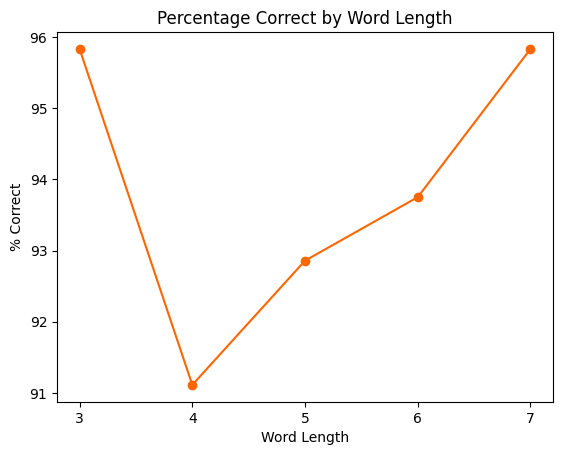

In [121]:
# Word length vs % correct


proportion_df = data.groupby('word_length')['score'].mean() * 100
print(proportion_df)
x = proportion_df.index
y = proportion_df.values

plt.plot(x, y, color = patient, marker =  'o')
# for i in range(len(x)):
#     plt.text(x[i], y[i]+1, round(y[i], 2), ha = 'center')

# Labels and title
plt.ylabel("% Correct")
plt.xlabel("Word Length")
plt.title("Percentage Correct by Word Length")


plt.xticks(x)

# Save plot
# save_plot("percentage correct by word length")


(70.0, 100.0)

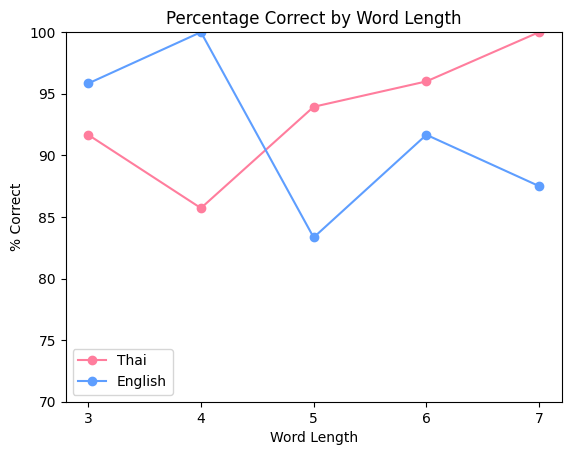

In [12]:

plot_data = data.groupby(['word_length', 'Language'], observed=True)['score'].mean().mul(100).unstack()
customorder = ['Thai', 'English']
plot_data = plot_data.reindex(columns=[col for col in customorder if col in plot_data.columns])

for lang, sublist in plot_data.items():
    x = sublist.index
    y = sublist.values
    colbylang = redgradient[2] if lang == 'Thai' else bluegradient[2] if lang == "English" else gaygradient[2]

    plt.plot(x, y, color = colbylang, marker = 'o', label = lang)

    # for x, y in zip(x, y):
    #     plt.text(x, y +0.2, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylabel("% Correct")
plt.xlabel("Word Length")
plt.title("Percentage Correct by Word Length")
plt.legend()
plt.xticks([3,4,5,6,7])
plt.ylim(70,100)

# save_plot("percentage correct by word length by language")


%correct vs stimuli

Text(0.5, 1.0, 'Percentage Correct by Stimuli type')

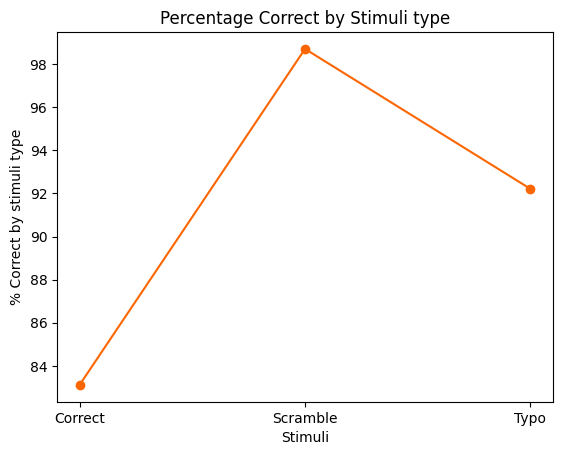

In [73]:
plot_data = data.groupby(['stimuli'])['score'].mean().mul(100)
plt.plot(plot_data.index, plot_data.values, color = patient, marker = 'o')

# for x, y in plot_data.items():
#     plt.text(x, y+1, f"{y:.2f}", ha = 'center')
plt.ylabel("% Correct by stimuli type")
plt.xlabel("Stimuli")
plt.title("Percentage Correct by Stimuli type")

# save_plot("percentage correct by stimuli overall")

stimuli    Correct  Scramble       Typo
lang                                   
1.0      97.500000      95.0  90.000000
2.0      78.378378     100.0  97.297297
<class 'list'>
<class 'list'>


(70.0, 100.0)

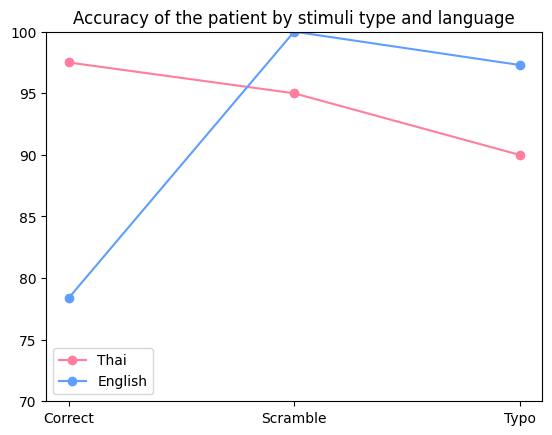

In [14]:
# Stimuli vs % correct
# fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10,4))
# plt.figure(figsize=(8,6))
plot_data = data.groupby(["lang", "stimuli"])['score'].mean().mul(100).unstack()
print(plot_data)
for i, (lang, fucker) in enumerate(plot_data.iterrows()):
    langauge = 'Thai' if lang == 1 else 'English'
    colbylang  = redgradient[2] if lang == 1 else bluegradient[2]
    print(list)
    plt.plot(fucker.index, fucker.values, marker = 'o', color = colbylang, label = langauge)
    
plt.title("Accuracy of the patient by stimuli type and language")
# plt.xticks([1,2,3], ['Correct', "Scramble", "Pseudo"])
plt.legend()
plt.ylim(70,100)
# Save plot
# save_plot("percentage correct by stimuli")


# Reactime vs lang

In [18]:
# filter onlt correct reaction time
datafilter = data[data['score'] == 1]


(0.0, 15.0)

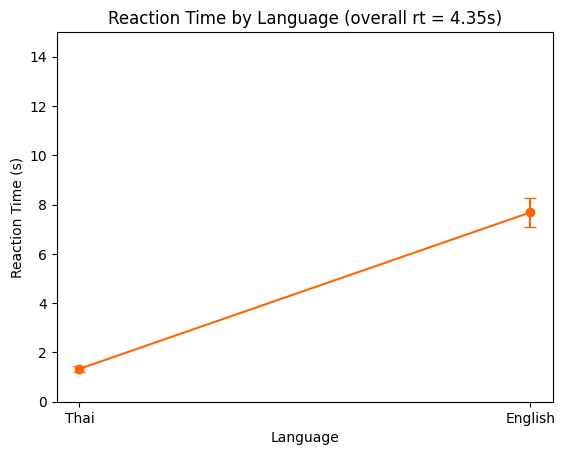

In [35]:
fig, ax = plt.subplots()
rtmeans = datafilter.groupby('Language')['key_resp.rt'].mean().reindex(['Thai', 'English'])
rtmeanall = datafilter['key_resp.rt'].mean()

rterr = datafilter.groupby('Language')['key_resp.rt'].sem().reindex(['Thai', 'English'])

plt.errorbar(rtmeans.index, rtmeans, yerr = rterr, color= patient,capsize = 4, marker = 'o')

plt.ylabel("Reaction Time (s)")
plt.title(f"Reaction Time by Language (overall rt = {round(rtmeanall,2)}s)" )
plt.xlabel('Language')
plt.ylim(0,15)
# for i in np.arange(len(rtmeans)):
#     x = rtmeans.index[i]
#     y = rtmeans.values[i]
#     yerr = rterr.values[i]
#     plt.text(x, y+yerr+0.2, f'{y:.2f}', ha='center', va='bottom', fontsize=10)
# save_plot( "reaction time by language")

Freedman-Diaconis Rule AND Create BOX plot AND Histogram

In [25]:
import matplotlib.font_manager as fm
thai_font_path="./THSarabun.ttf"
def II_plot_RT_outliers(df, lang, title,  ylim = None,save_path=None):
    RT = 'key_resp.rt'
    # Calculate outlier thresholds using IQR method
    # Q1 = df[RT].quantile(0.25)
    # Q3 = df[RT].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR

    # # Find outliers
    # outliers = df[(df[RT] < lower_bound) | (df[RT] > upper_bound)]
    # outliers.sort_values(by=[RT], inplace = True)

    # Create the plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)

    # Boxplot (Top)
    sns.boxplot(data=df, x=RT, ax=axes[0], color='lightgray')
    axes[0].set_title(title)
    axes[0].set_xlabel('')
    # axes[0].set_xlim(0,50)
#     # Annotate outliers with the corresponding 'word shown' using the Thai font if provided
#     prop = fm.FontProperties(fname=thai_font_path)
#     i = 0
#     for outlier_value, word in zip(outliers[RT], outliers['word shown']):
#         yax = 0 + 0.25 * ((-1) ** i)
#         axes[0].text(outlier_value, yax, word, fontsize=10, ha='center', va = 'center',color='black', fontweight='light', rotation=90, fontproperties=prop)
#         i = i + 1
# # 
    # axes[0].set_yticks([])  # Hide y-axis ticks
    # axes[0].set_xlabel("")  # Remove x-axis label

    # Histogram (Bottom)

    num_bins = 23
    colorchoice = redgradient[2] if lang == 'th' else bluegradient[2] if lang == 'en' else gaygradient[2] 
    axes[1].hist(df[RT], bins=num_bins,range = (0,46) ,color=colorchoice, alpha=0.7, edgecolor='black')
    axes[1].set_title('')
    axes[1].set_xlabel("Reaction Time (s)")
    axes[1].set_ylabel("Frequency")
    # axes[1].set_xticks(np.arange(0,16,1))
    axes[1].set_xlim(0,46)
    if ylim != None:
        axes[1].set_ylim(0,ylim)
    
    # save_plot(f"RT hist and boxplot {lang}")


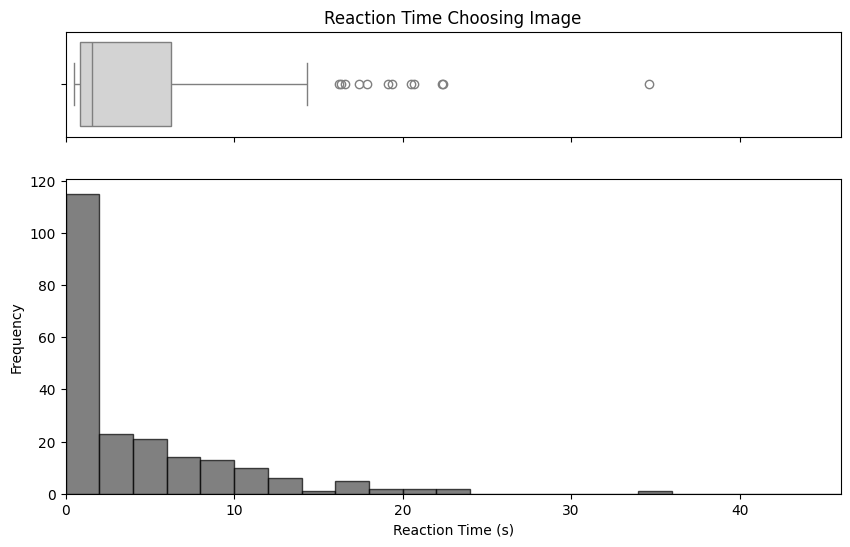

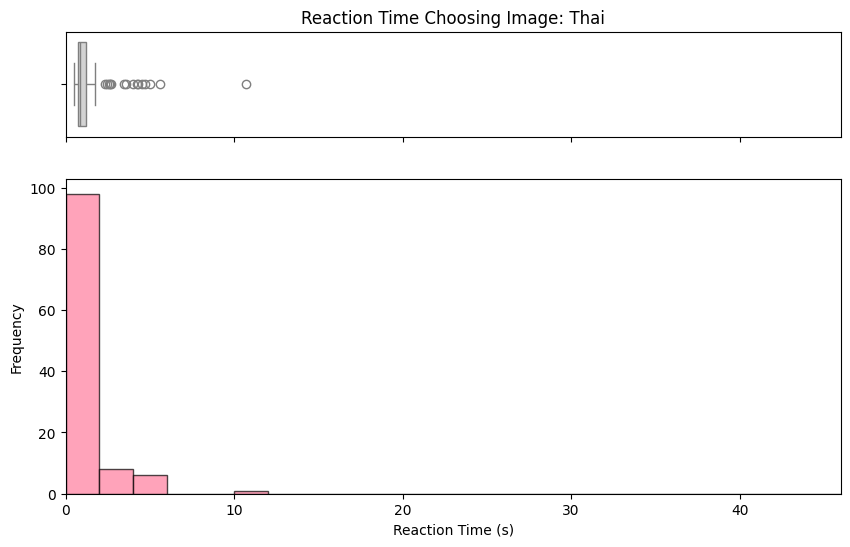

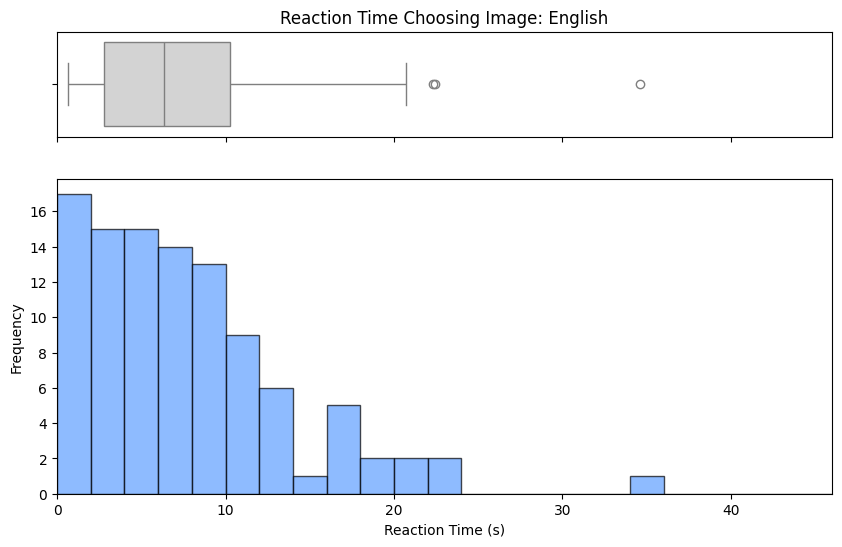

In [26]:
II_plot_RT_outliers(datafilter, '',"Reaction Time Choosing Image")
II_plot_RT_outliers(datafilter[datafilter['Language'] == 'Thai'], 'th',"Reaction Time Choosing Image: Thai")
II_plot_RT_outliers(datafilter[datafilter['Language'] == 'English'], 'en',"Reaction Time Choosing Image: English")

Language VS Reaction Time Histogram

# Word Length vs Reaction Time Graphs

(0.0, 8.105110560093937)

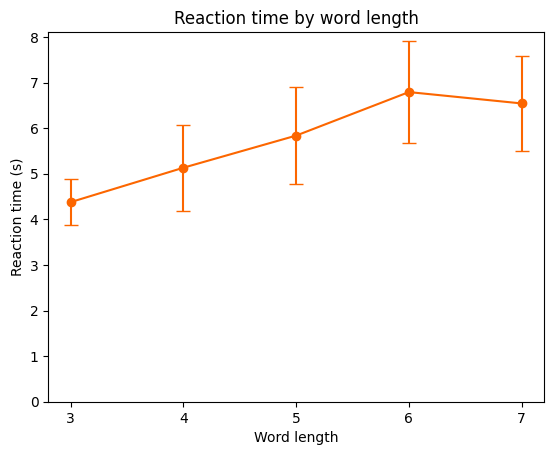

In [133]:
rtlen = datafilter.groupby('word_length')['key_resp.rt'].mean()
rterr = datafilter.groupby('word_length')['key_resp.rt'].sem()

# plt.figure(figsize=(8, 5))
plt.errorbar(rtlen.index, rtlen.values, marker = 'o', color = patient, yerr = rterr.values, capsize = 5)


plt.title("Reaction time by word length")
plt.xlabel("Word length")
plt.xticks(rtlen.index)
plt.ylabel('Reaction time (s)')
plt.ylim(0)
# save_plot("Reaction time by word length")

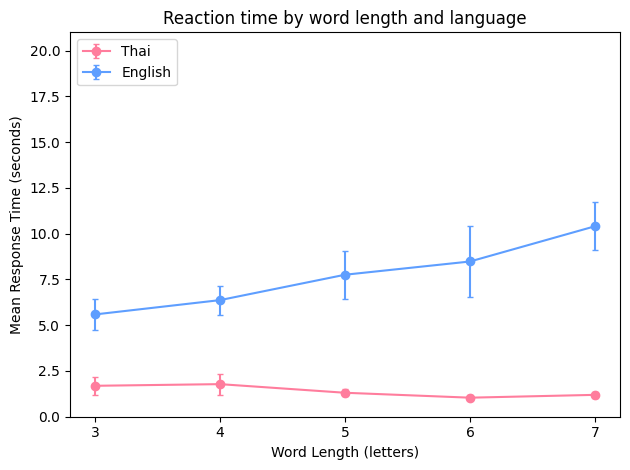

In [36]:

# Set the figure size and bar width
rtlen = datafilter.groupby(['word_length', 'Language'], observed=True)['key_resp.rt'].mean().unstack()
rterr = datafilter.groupby(['word_length', 'Language'], observed=True)['key_resp.rt'].sem().unstack()
rtlen = rtlen.loc[:, ['Thai', 'English']]
rterr = rterr.loc[:, ['Thai', 'English']]


# plt.figure(figsize=(8, 5))  # Adjust the width and height here
for lang, sublist in rtlen.items():
    yerr = rterr[lang]
    colorchoice = redgradient[2] if lang == 'Thai' else bluegradient[2] if lang == 'English' else gaygradient[4]
     
    plt.errorbar(sublist.index, sublist.values, yerr = rterr[lang], capsize = 2, fmt = 'o-', color = colorchoice, label = lang)





plt.xlabel('Word Length (letters)')
plt.ylabel('Mean Response Time (seconds)')
plt.title("Reaction time by word length and language")
plt.xticks(rtlen.index)
plt.legend(loc = 'upper left')
plt.ylim(0,21)
# Save the plot to the specified directory
plt.tight_layout()
# save_plot("Reaction time by word length and language")


# Stimuli Type vs Reaction Time Graphs

stimuli
Correct     8.541653
Scramble    6.378466
Typo        9.114607
Name: key_resp.rt, dtype: float64


(0.0, 10.349602783451628)

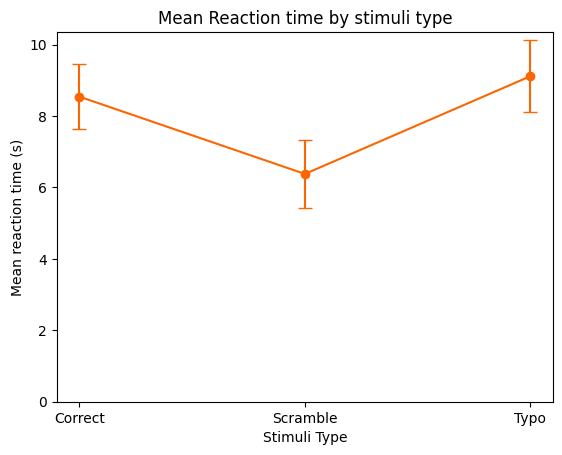

In [102]:
plot_data = datafilter.groupby(['stimuli'])['key_resp.rt'].mean()
sem = datafilter.groupby(['stimuli'])['key_resp.rt'].sem()
print(plot_data)
plt.errorbar(plot_data.index, plot_data.values, yerr = sem.values, capsize=5, marker = 'o', color = patient )
sem = datafilter.groupby(['stimuli'])['key_resp.rt'].sem()


plt.title("Mean Reaction time by stimuli type")
plt.ylabel("Mean reaction time (s)")
plt.xlabel("Stimuli Type")
plt.ylim(0)
# plt.xticks([1,2,3], ['Correct', 'Scramble', "Pseudo"])
# save_plot("mean reaction time by stimuli type")


(0.0, 20.0)

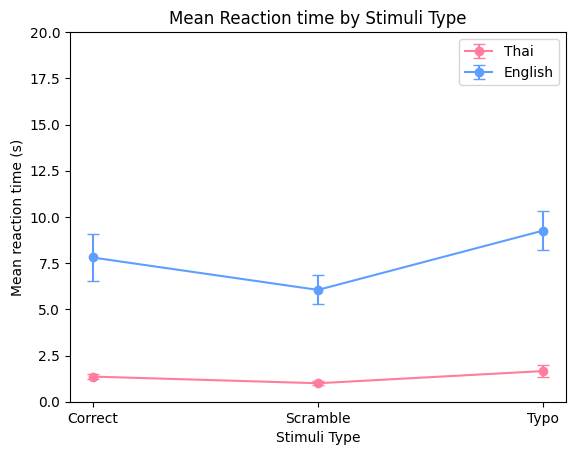

In [38]:
# Stimuli vs % correct
plt.figure()
plot_data = datafilter.groupby(['stimuli', 'lang'], observed=True)['key_resp.rt'].mean().unstack()
plot_dataerr = datafilter.groupby(['stimuli', 'lang'], observed=True)['key_resp.rt'].sem().unstack()
 

for ni, ge in plot_data.items():
    language = 'Thai' if ni == 1 else 'English'
    colbylang = redgradient[2] if ni == 1 else bluegradient[2]
    plt.errorbar(ge.index, ge.values, color = colbylang, label = language, yerr = plot_dataerr[ni].values, capsize = 4, marker = 'o')



# Labels and title
plt.ylabel("Mean reaction time (s)")
plt.xlabel("Stimuli Type")
plt.title("Mean Reaction time by Stimuli Type")
plt.legend()
plt.ylim(0,20)
# plt.xticks([1,2,3], ["Correct", "Scramble", "Pseudo"])
# save_plot("Reaction time by stimuli")